<a href="https://colab.research.google.com/github/drichardcarl/colab-ipynb/blob/master/BNBUSDT_LSTM_TA_RL_cryptoenv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# !pip uninstall -y tensorflow
# !pip install tensorflow==1.13.2
 
# !pip uninstall -y keras-nightly
# !pip uninstall -y tensorflow
# !pip install tensorflow==1.14
 
!pip install gym gym_anytrading quantstats stable_baselines==2.10.2 prefixed

     |████████████████████████████████| 171 kB 29.1 MB/s 
     |████████████████████████████████| 240 kB 42.5 MB/s 
     |████████████████████████████████| 6.3 MB 49.9 MB/s 
  Created wheel for quantstats: filename=QuantStats-0.0.34-py2.py3-none-any.whl size=37850 sha256=16062fae0a329f39393ddd5769a3163873af73cd3af319a4396cafbeb3c7a953
  Stored in directory: /root/.cache/pip/wheels/bb/eb/d5/034cb7967c8a31d4c2153df9bf43c5e172b999f4cc192aa1d8
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=516ffc206667a0f4b3445bf5aede7a01f4a57c527a46259cbb9f8beeff6f175a
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built quantstats yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Attempting uninstall: stable-baselines
    Found existing installation: stable-baselines 2.2.1
    Uninst

In [ ]:
from google.colab import drive
drive.mount('./Drive', force_remount=True)

Mounted at ./Drive


In [ ]:
import os
if not os.path.exists('ta-lib-0.4.0-src.tar.gz'):
    !cp './Drive/MyDrive/crypto/ta-lib-0.4.0-src.tar.gz' .
    !tar -xvf ta-lib-0.4.0-src.tar.gz
    !cd ta-lib && ./configure --prefix=/usr
    !cd ta-lib && make
    !cd ta-lib && sudo make install
 
!pip install TA-Lib

ta-lib/
ta-lib/config.sub
ta-lib/aclocal.m4
ta-lib/CHANGELOG.TXT
ta-lib/include/
ta-lib/include/ta_abstract.h
ta-lib/include/ta_func.h
ta-lib/include/ta_common.h
ta-lib/include/ta_config.h.in
ta-lib/include/Makefile.am
ta-lib/include/ta_libc.h
ta-lib/include/ta_defs.h
ta-lib/missing
ta-lib/ta-lib.spec.in
ta-lib/config.guess
ta-lib/Makefile.in
ta-lib/ta-lib.dpkg.in
ta-lib/Makefile.am
ta-lib/autogen.sh
ta-lib/install-sh
ta-lib/configure
ta-lib/depcomp
ta-lib/HISTORY.TXT
ta-lib/configure.in
ta-lib/autom4te.cache/
ta-lib/autom4te.cache/output.0
ta-lib/autom4te.cache/requests
ta-lib/autom4te.cache/output.1
ta-lib/autom4te.cache/traces.0
ta-lib/autom4te.cache/traces.1
ta-lib/ltmain.sh
ta-lib/ta-lib-config.in
ta-lib/src/
ta-lib/src/ta_func/
ta-lib/src/ta_func/ta_MACDFIX.c
ta-lib/src/ta_func/ta_CDLPIERCING.c
ta-lib/src/ta_func/ta_DIV.c
ta-lib/src/ta_func/ta_ROCR100.c
ta-lib/src/ta_func/ta_ADXR.c
ta-lib/src/ta_func/ta_MAVP.c
ta-lib/src/ta_func/ta_CDLCLOSINGMARUBOZU.c
ta-lib/src/ta_func/ta_COSH.

In [ ]:
import pandas as pd
from datetime import datetime
 
crypto = './Drive/MyDrive/crypto/BNBUSDT' # Google Colaboratory #
 
# preprocess
# df = pd.read_csv(f"{crypto}/BNBUSDT-1h-022020-062021.csv", usecols=[0,1,2,3,4,5], names=['Time','Open', 'High', 'Low', 'Close', 'Volume'])
# df = df.sort_values('Time')
# df['Time'] = df['Time'].map(lambda x: datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))
# df = df.set_index('Time')

df = pd.read_csv(f"{crypto}/BNB-USD.yfinance.csv")
df = df.set_index('Date')

print(df.isnull().any(), df.shape)
df = df.dropna(how='any',axis=0)
print()
print(df.isnull().any(), df.shape)
print()
print(df)

Open         True
High         True
Low          True
Close        True
Adj Close    True
Volume       True
dtype: bool (1456, 6)

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool (1452, 6)

                  Open        High  ...   Adj Close        Volume
Date                                ...                          
2017-07-25    0.115203    0.115841  ...    0.105870  1.452690e+05
2017-07-26    0.105893    0.109013  ...    0.105138  2.003950e+05
2017-07-27    0.105108    0.108479  ...    0.107737  3.444990e+05
2017-07-28    0.107632    0.109019  ...    0.104067  3.425680e+05
2017-07-29    0.104782    0.111264  ...    0.107811  3.402180e+05
...                ...         ...  ...         ...           ...
2021-07-15  309.500641  323.885895  ...  315.244019  2.242114e+09
2021-07-16  315.691101  322.997772  ...  302.985596  1.688212e+09
2021-07-17  302.934845  306.530853  ...  300.497925  1.298507e+09
2021-0

In [ ]:
# add new features
import talib
import numpy as np
 
def _nan20(d):
    # d[np.isnan(d)] = 0
    return d

def _nan2zero(d):
    d[np.isnan(d)] = 0
    return d
 
popen = df['Open'].to_numpy()
phigh = df['High'].to_numpy()
plow = df['Low'].to_numpy()
pclose = df['Close'].to_numpy()
 
# Overlap Studies
ubband, mbband, lbband = (_nan20(i) for i in talib.BBANDS(pclose))
df['U_BBANDS'] = ubband
df['M_BBANDS'] = mbband
df['L_BBANDS'] = lbband
df['DEMA'] = _nan20(talib.DEMA(pclose))
df['EMA'] = _nan20(talib.EMA(pclose))
df['HT_TRENDLINE'] = _nan20(talib.HT_TRENDLINE(pclose))
df['KAMA'] = _nan20(talib.KAMA(pclose))
df['MIDPOINT'] = _nan20(talib.MIDPOINT(pclose))
df['MIDPRICE'] = _nan20(talib.MIDPRICE(phigh, plow))
df['SAR'] = _nan20(talib.SAR(phigh, plow))
df['SAREXT'] = _nan20(talib.SAREXT(phigh, plow))
df['SMA3'] = _nan20(talib.SMA(pclose, timeperiod=3))
df['SMA5'] = _nan20(talib.SMA(pclose, timeperiod=5))
df['SMA10'] = _nan20(talib.SMA(pclose, timeperiod=10))
df['SMA20'] = _nan20(talib.SMA(pclose, timeperiod=20))
df['TEMA'] = _nan20(talib.TEMA(pclose))
df['TRIMA'] = _nan20(talib.TRIMA(pclose))
df['WMA'] = _nan20(talib.TRIMA(pclose))
 
# Momentum Indicators
df['ADX14'] = _nan20(talib.ADX(phigh, plow, pclose, timeperiod=14))
df['ADX20'] = _nan20(talib.ADX(phigh, plow, pclose, timeperiod=20))
df['ADXR'] = _nan20(talib.ADXR(phigh, plow, pclose))
df['APO'] = _nan20(talib.APO(pclose))
df['AROONOSC'] = _nan20(talib.AROONOSC(phigh, plow))
df['BOP'] = _nan20(talib.BOP(popen, phigh, plow, pclose))
df['CCI3'] = _nan20(talib.CCI(phigh, plow, pclose, timeperiod=3))
df['CCI5'] = _nan20(talib.CCI(phigh, plow, pclose, timeperiod=5))
df['CCI10'] = _nan20(talib.CCI(phigh, plow, pclose, timeperiod=10))
df['CCI14'] = _nan20(talib.CCI(phigh, plow, pclose, timeperiod=14))
df['CMO'] = _nan20(talib.CMO(pclose))
df['DX'] = _nan20(talib.DX(phigh, plow, pclose))
macd, macdsignal, macdhist = (_nan20(i) for i in talib.MACD(pclose))
df['MACD'] = macd
df['MACDSIGNAL'] = macdsignal
df['MACDHIST'] = macdhist
df['MINUS_DI'] = _nan20(talib.MINUS_DI(phigh, plow, pclose))
df['MINUS_DM'] = _nan20(talib.MINUS_DM(phigh, plow))
df['MOM1'] = _nan20(talib.MOM(pclose, timeperiod=1))
df['MOM3'] = _nan20(talib.MOM(pclose, timeperiod=3))
df['MOM5'] = _nan20(talib.MOM(pclose, timeperiod=5))
df['MOM10'] = _nan20(talib.MOM(pclose, timeperiod=10))
df['PLUS_DI'] = _nan20(talib.PLUS_DI(phigh, plow, pclose))
df['PLUS_DM'] = _nan20(talib.PLUS_DM(phigh, plow))
df['PPO'] = _nan20(talib.PPO(pclose))
df['ROC'] = _nan20(talib.ROC(pclose))
df['ROCP'] = _nan20(talib.ROCP(pclose))
df['ROCR'] = _nan20(talib.ROCR(pclose))
df['ROCR100'] = _nan20(talib.ROCR100(pclose))
df['RSI5'] = _nan20(talib.RSI(pclose, timeperiod=5))
df['RSI10'] = _nan20(talib.RSI(pclose, timeperiod=10))
df['RSI14'] = _nan20(talib.RSI(pclose, timeperiod=14))
slowk, slowd = (_nan20(i) for i in talib.STOCH(phigh, plow, pclose))
df['SLOWK'] = slowk
df['SLOWD'] = slowd
fastk, fastd = (_nan20(i) for i in talib.STOCHF(phigh, plow, pclose))
df['FASTK'] = fastk
df['FASTD'] = fastd
df['TRIX'] = _nan20(talib.TRIX(pclose))
df['ULTOSC'] = _nan20(talib.ULTOSC(phigh, plow, pclose))
df['WILLR'] = _nan20(talib.WILLR(phigh, plow, pclose))
 
# Volatility Indicators
df['ATR'] = _nan20(talib.ATR(phigh, plow, pclose))
df['NATR'] = _nan20(talib.NATR(phigh, plow, pclose))
df['TRANGE'] = _nan20(talib.TRANGE(phigh, plow, pclose))
 
# Pattern Recognition
patterns = [
  'CDL2CROWS',
  'CDL3BLACKCROWS',
  'CDL3INSIDE',
  'CDL3LINESTRIKE',
  'CDL3OUTSIDE',
  'CDL3STARSINSOUTH',
  'CDL3WHITESOLDIERS',
  'CDLABANDONEDBABY',
  'CDLADVANCEBLOCK',
  'CDLBELTHOLD',
  'CDLBREAKAWAY',
  'CDLCLOSINGMARUBOZU',
  'CDLCONCEALBABYSWALL',
  'CDLCOUNTERATTACK',
  'CDLDARKCLOUDCOVER',
  'CDLDOJI',
  'CDLDOJISTAR',
  'CDLDRAGONFLYDOJI',
  'CDLENGULFING',
  'CDLEVENINGDOJISTAR',
  'CDLEVENINGSTAR',
  'CDLGAPSIDESIDEWHITE',
  'CDLGRAVESTONEDOJI',
  'CDLHAMMER',
  'CDLHANGINGMAN',
  'CDLHARAMI',
  'CDLHARAMICROSS',
  'CDLHIGHWAVE',
  'CDLHIKKAKE',
  'CDLHIKKAKEMOD',
  'CDLHOMINGPIGEON',
  'CDLIDENTICAL3CROWS',
  'CDLINNECK',
  'CDLINVERTEDHAMMER',
  'CDLKICKING',
  'CDLKICKINGBYLENGTH',
  'CDLLADDERBOTTOM',
  'CDLLONGLEGGEDDOJI',
  'CDLLONGLINE',
  'CDLMARUBOZU',
  'CDLMATCHINGLOW',
  'CDLMATHOLD',
  'CDLMORNINGDOJISTAR',
  'CDLMORNINGSTAR',
  'CDLONNECK',
  'CDLPIERCING',
  'CDLRICKSHAWMAN',
  'CDLRISEFALL3METHODS',
  'CDLSEPARATINGLINES',
  'CDLSHOOTINGSTAR',
  'CDLSHORTLINE',
  'CDLSPINNINGTOP',
  'CDLSTALLEDPATTERN',
  'CDLSTICKSANDWICH',
  'CDLTAKURI',
  'CDLTASUKIGAP',
  'CDLTHRUSTING',
  'CDLTRISTAR',
  'CDLUNIQUE3RIVER',
  'CDLUPSIDEGAP2CROWS',
  'CDLXSIDEGAP3METHODS',
]
for pat in patterns:
  df[pat] = _nan20(getattr(talib,pat)(popen, phigh, plow, pclose))
 
# Cycle Indicators
df['HT_DCPERIOD'] = _nan20(talib.HT_DCPERIOD(pclose))
df['HT_DCPHASE'] = _nan20(talib.HT_DCPHASE(pclose))
df['HT_TRENDMODE'] = _nan20(talib.HT_TRENDMODE(pclose))

# df = (df-df.mean())/df.std()
df = _nan2zero(df)
# df = df-df.min()+1 # min must be 1

print(df.isnull().any())
print(df.min())
print(df)
 
# resave
fn = f"{crypto}/BNBUSDT.yfinance.p.csv"
df.to_csv(fn)

Open                   False
High                   False
Low                    False
Close                  False
Adj Close              False
                       ...  
CDLUPSIDEGAP2CROWS     False
CDLXSIDEGAP3METHODS    False
HT_DCPERIOD            False
HT_DCPHASE             False
HT_TRENDMODE           False
Length: 129, dtype: bool
Open                     0.099721
High                     0.101211
Low                      0.096109
Close                    0.099867
Adj Close                0.099867
                          ...    
CDLUPSIDEGAP2CROWS       0.000000
CDLXSIDEGAP3METHODS   -100.000000
HT_DCPERIOD              0.000000
HT_DCPHASE             -44.953092
HT_TRENDMODE             0.000000
Length: 129, dtype: float64
                  Open        High  ...  HT_DCPHASE  HT_TRENDMODE
Date                                ...                          
2017-07-25    0.115203    0.115841  ...    0.000000             0
2017-07-26    0.105893    0.109013  ...    0.000000     

In [ ]:
# reload
fn = f"{crypto}/BNBUSDT-1h-022020-062021.p.csv"
df = pd.read_csv(fn, parse_dates=True, index_col='Time')

# fn = f"{crypto}/BNBUSDT.yfinance.p.csv"
# df = pd.read_csv(fn, parse_dates=True, index_col='Date')

print(df.isnull().any())
print(df.min())
print(df)

ldf = int(0.95*len(df))
train_df = df.iloc[:ldf]
test_df = df.iloc[ldf:]
print(train_df.shape, test_df.shape)

Open                   False
High                   False
Low                    False
Close                  False
Volume                 False
                       ...  
CDLUPSIDEGAP2CROWS     False
CDLXSIDEGAP3METHODS    False
HT_DCPERIOD            False
HT_DCPHASE             False
HT_TRENDMODE           False
Length: 128, dtype: bool
Open                      7.707000
High                      8.753000
Low                       6.236000
Close                     7.716000
Volume                 1651.830000
                          ...     
CDLUPSIDEGAP2CROWS        0.000000
CDLXSIDEGAP3METHODS    -100.000000
HT_DCPERIOD               0.000000
HT_DCPHASE              -44.979106
HT_TRENDMODE              0.000000
Length: 128, dtype: float64
                        Open     High  ...  HT_DCPHASE  HT_TRENDMODE
Time                                   ...                          
2020-02-10 08:00:00   25.070   25.907  ...    0.000000             0
2020-02-10 09:00:00   25.054   25.05

In [ ]:
# standardize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#df = (df-df.mean())/df.std()
#scaler = scaler.fit(df)
 
def _norm(df):
  return pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
 
# df = _norm(df)
# print(scaler)
print(df.isnull().any())
print(df.mean())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import random
from gym import spaces

MAX_ACCOUNT_BALANCE = 10000000
INITIAL_ACCOUNT_BALANCE = 1000
MAX_CRYPTO_PRICE = 20000
MAX_CRYPTO = 21000000
MAKER_FEE = 0.00075
TAKER_FEE = 0.00075
BNBUSDTHELD = 1000
MAX_STEPS = 500

class CryptoEnv(gym.Env):
    def __init__(self, df, ep_len, window_size):
        global MAX_STEPS
        MAX_STEPS = ep_len-1-window_size

        self.df = df
        self.window_size = window_size
        self.frame_bound = (self.window_size, len(self.df)-MAX_STEPS)
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])
        self.reward_range = (-MAX_ACCOUNT_BALANCE,
                             MAX_ACCOUNT_BALANCE)
        self.total_fees = 0
        self.total_volume_traded = 0
        self.crypto_held = 0
        self.bnb_usdt_held = BNBUSDTHELD
        self.bnb_usdt_held_start = BNBUSDTHELD
        self.episode = 1

        # Graph to render
        self.graph_reward = []
        self.graph_profit = []
        self.graph_benchmark = []
        self.history = {}

        # Action space from -1 to 1, -1 is short, 1 is buy
        self.action_space = spaces.Box(low=-1,
                                       high=1,
                                       shape=(1, ),
                                       dtype=np.float32)
        # Observation space contains only the actual price for the moment
        self.observation_space = spaces.Box(low=-np.inf,
                                            high=np.inf,
                                            shape=self.shape,
                                            dtype=np.float32)

    def reset(self):
        self.history = {}

        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE + BNBUSDTHELD
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.total_fees = 0
        self.total_volume_traded = 0
        self.crypto_held = 0
        self.bnb_usdt_held = BNBUSDTHELD
        self.episode_reward = 0

        # Set the current step to a random point within the data frame
        # Weights of the current step follow the square function
        
        # a, b = self.frame_bound
        # start = list(range(a, b))
        # weights = [i for i in start]
        # self.current_step = random.choices(start, weights)[0]
        # self.start_step = self.current_step

        a, b = self.frame_bound
        start = list(range(a, b)) + [a]
        random.shuffle(start)
        self.current_step = random.choice(start)
        self.start_step = self.current_step

        return self._next_observation()

    def _next_observation(self):
        return self.signal_features[(self.current_step-self.window_size):self.current_step]

    def _take_action(self, action):
        # Set the current price to a random price between open and close
        current_price = random.uniform(
            self.df.loc[self.df.index[self.current_step], 'Open'],
            self.df.loc[self.df.index[self.current_step], 'Close'])

        if action[0] > 0:
            # Buy
            crypto_bought = self.balance * action[0] / current_price
            self.bnb_usdt_held -= crypto_bought * current_price * MAKER_FEE
            self.total_fees += crypto_bought * current_price * MAKER_FEE
            self.total_volume_traded += crypto_bought * current_price
            self.balance -= crypto_bought * current_price
            self.crypto_held += crypto_bought

        if action[0] < 0:
            # Sell
            crypto_sold = -self.crypto_held * action[0]
            self.bnb_usdt_held -= crypto_sold * current_price * TAKER_FEE
            self.total_fees += crypto_sold * current_price * TAKER_FEE
            self.total_volume_traded += crypto_sold * current_price
            self.balance += crypto_sold * current_price
            self.crypto_held -= crypto_sold

        self.net_worth = self.balance + self.crypto_held * current_price + self.bnb_usdt_held

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

    def step(self, action, end=True):
        # Execute one time step within the environment
        self._take_action(action)

        self.current_step += 1

        # Calculus of the reward
        profit, profit_percent, benchmark_profit = self.step_profits()

        diff = profit_percent - benchmark_profit
        reward = np.sign(diff) * (diff)**2

        # A single episode can last a maximum of MAX_STEPS steps
        if self.current_step >= MAX_STEPS + self.start_step:
            end = True
        else:
            end = False

        done = self.net_worth <= 0 or self.bnb_usdt_held <= 0 or end

        if done and end:
            self.episode_reward = reward
            self._render_episode()
            self.graph_profit.append(profit_percent)
            self.graph_benchmark.append(benchmark_profit)
            self.graph_reward.append(reward)
            self.episode += 1

        obs = self._next_observation()

        info = {
            'reward': reward,
            'balance': self.balance,
            'net_worth': self.net_worth,
            'profit': profit_percent,
            'benchmark_profit': benchmark_profit,
        }
        self._update_history(info)

        return obs, reward, done and end, info
    
    def step_profits(self):
        profit = self.net_worth - (INITIAL_ACCOUNT_BALANCE +
                                   BNBUSDTHELD)

        profit_percent = profit / (INITIAL_ACCOUNT_BALANCE +
                                   BNBUSDTHELD) * 100

        benchmark_profit = (self.df.loc[self.df.index[self.current_step], 'Open'] /
                            self.df.loc[self.df.index[self.start_step], 'Open'] -
                            1) * 100
        
        return profit, profit_percent, benchmark_profit

    def render(self, print_step=False, graph=False, *args):
        profit, profit_percent, benchmark_profit = self.step_profits()

        if print_step:
            print("----------------------------------------")
            print(f'Step: {self.current_step}')
            print(f'Balance: {round(self.balance, 2)}')
            print(f'Crypto held: {round(self.crypto_held, 2)}')
            print(f'Fees paid: {round(self.total_fees, 2)}')
            print(f'Volume traded: {round(self.total_volume_traded, 2)}')
            print(f'Net worth: {round(self.max_net_worth, 2)}')
            print(f'Max net worth: {round(self.max_net_worth, 2)}')
            print(f'Profit: {round(profit_percent, 2)}% ({round(profit, 2)})')
            print(f'Benchmark profit: {round(benchmark_profit, 2)}')

        # Plot the graph of the reward
        if graph:
            fig = plt.figure()
            fig.suptitle('Training graph')

            high = plt.subplot(2, 1, 1)
            high.set(ylabel='Gain')
            plt.plot(self.graph_profit, label='Bot profit')
            plt.plot(self.graph_benchmark, label='Benchmark profit')
            high.legend(loc='upper left')

            low = plt.subplot(2, 1, 2)
            low.set(xlabel='Episode', ylabel='Reward')
            plt.plot(self.graph_reward, label='reward')

            plt.show()

        return profit_percent, benchmark_profit

    def _render_episode(self):
        print('-----------------------')
        print(f'Episode: {self.episode}')
        print(f'Profit: {round(self.render()[0], 2)}%')
        print(f'Benchmark profit: {round(self.render()[1], 2)}%')
        print(f'Reward: {round(self.episode_reward, 2)}')
    
    def _process_data(self):
        start = 0
        end = len(self.df)
        prices = self.df.loc[:, 'Close'].to_numpy()[start:end]
        signal_features = self.df.to_numpy()[start:end]
 
        return prices, signal_features
    
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}
 
        for key, value in info.items():
            self.history[key].append(value)
    
    def info(self):
        profits = self.history['profit']
        benchmark_profit = self.history['benchmark_profit']
        rnge = range(self.start_step, self.start_step+len(profits))
        x = [i for i in rnge]
        # print(rnge, x)
        prices = self.prices[rnge]

        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('tick')
        ax1.set_ylabel('profit', color=color)
        ax1.plot(x, profits, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('price', color=color)  # we already handled the x-label with ax1
        ax2.plot(x, prices, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

-----------------------
Episode: 1
Profit: -7.49%
Benchmark profit: -2.68%
Reward: -23.07
info: {'reward': -23.0660825904991, 'balance': 742.4619547684935, 'net_worth': 1850.2529696027832, 'profit': -7.487351519860839, 'benchmark_profit': -2.684635351847253}


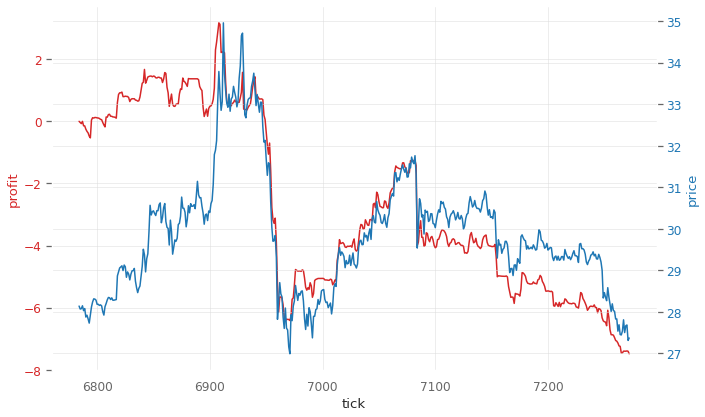

-----------------------
Episode: 2
Profit: -9.09%
Benchmark profit: -14.64%
Reward: 30.79
info: {'reward': 30.793403582520963, 'balance': 509.3228606717805, 'net_worth': 1818.2597944120587, 'profit': -9.087010279397067, 'benchmark_profit': -14.636190721815655}


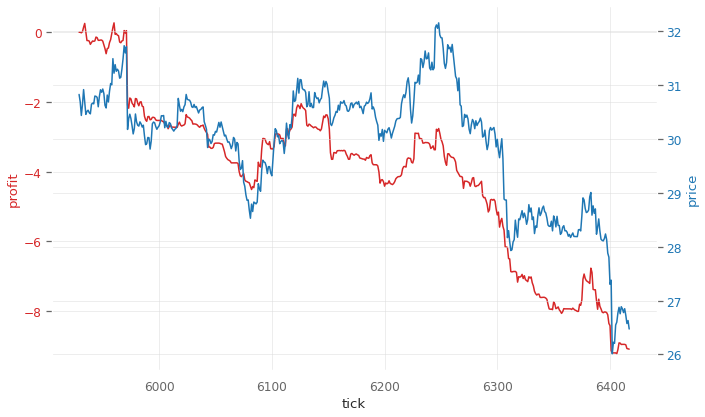

-----------------------
Episode: 3
Profit: -3.55%
Benchmark profit: 17.4%
Reward: -438.91
info: {'reward': -438.9103374160038, 'balance': 969.6597646734414, 'net_worth': 1929.0681980626714, 'profit': -3.54659009686643, 'benchmark_profit': 17.403596952799827}


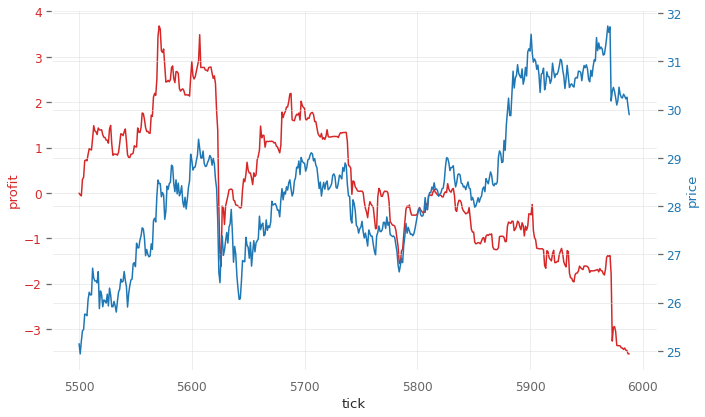

-----------------------
Episode: 4
Profit: -5.65%
Benchmark profit: -7.42%
Reward: 3.13
info: {'reward': 3.1320681311036638, 'balance': 522.3542785667737, 'net_worth': 1886.987033212388, 'profit': -5.650648339380598, 'benchmark_profit': -7.420413332565756}


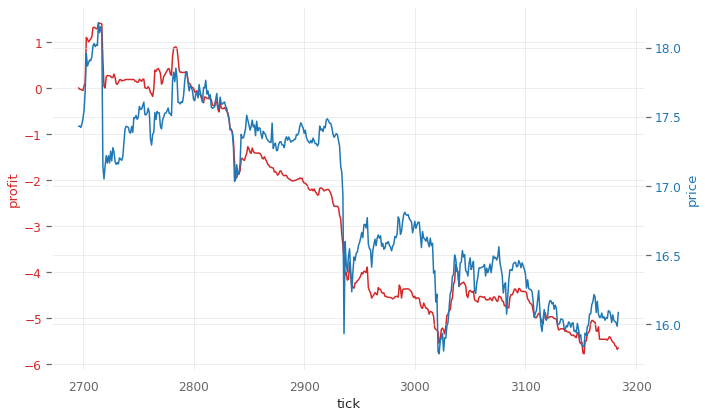

-----------------------
Episode: 5
Profit: 7.66%
Benchmark profit: 79.73%
Reward: -5194.23
info: {'reward': -5194.226013278329, 'balance': 795.0876858744682, 'net_worth': 2153.194084550563, 'profit': 7.659704227528142, 'benchmark_profit': 79.73068322239354}


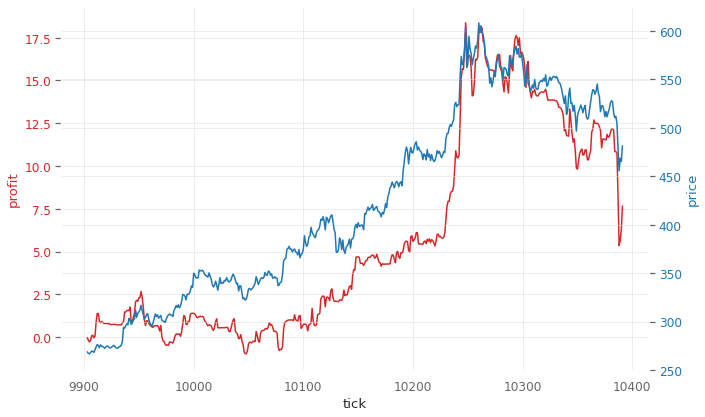

----------------------------------------
Step: 10392
Balance: 795.09
Crypto held: 0.97
Fees paid: 108.41
Volume traded: 144551.11
Net worth: 2367.28
Max net worth: 2367.28
Profit: 7.66% (153.19)
Benchmark profit: 79.73


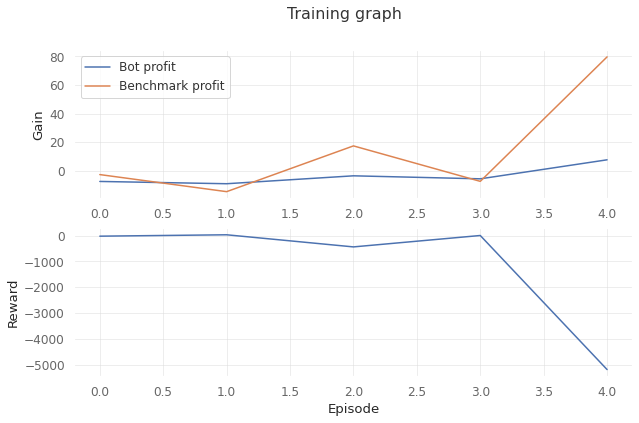

(7.659704227528142, 79.73068322239354)

In [ ]:
import gym
import gym_anytrading
# from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
import matplotlib.pyplot as plt
import time
 
# env = BinanceFuturesEnv(df=df, frame_bound=(10, -1), window_size=10)
env = CryptoEnv(df=train_df, ep_len=500, window_size=10)
# env = gym.make('forex-v0', df=df, frame_bound=(50, -1), window_size=10, unit_side='right')
# env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)
 
n_eps = 5
for i in range(n_eps):
    observation = env.reset()
    while True:
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("info:", info)
            env.info()
            # print(env._position_history)
            break
 
env.render(print_step=True, graph=True)
# plt.cla()
# env.render_all()
# plt.show()

In [ ]:
env.current_step

11550

In [ ]:
# imports
 
import numpy as np
import pandas as pd
 
import gym
import gym_anytrading
import quantstats as qs
 
from stable_baselines import A2C, PPO2
from stable_baselines.common.vec_env import DummyVecEnv, VecCheckNan
from stable_baselines.common import make_vec_env
 
import matplotlib.pyplot as plt

In [ ]:
# create env
window_size = 10
start_index = window_size
end_index = len(train_df)
# end_index = 9000
 
env_maker = lambda: CryptoEnv(
    df=train_df,
    ep_len=500,
    window_size=window_size,
)

# env_maker = lambda: BinanceFuturesEnv(
#     df=df,
#     frame_bound=(start_index, end_index),
#     window_size=window_size,
#     # initial_balance=5,
#     # leverage=50,
#     # trade_bal_pct=0.25,
# )
 
env = make_vec_env(env_maker, n_envs=4)
# env = DummyVecEnv([env_maker])
# env = VecCheckNan(env, raise_exception=True)

In [ ]:
print(env.action_space, env.observation_space)
# print(env.prices)
# print(env.signal_features)

Discrete(2) Box(-inf, inf, (10, 128), float32)


In [ ]:
# load tensorboard
%load_ext tensorboard

In [ ]:
# launch tensorboard
tensorboard_log=f"{crypto}/tb_cryptoenv"
# %tensorboard --logdir $tensorboard_log

In [ ]:
import time
eps = 2
ts = env.num_envs * len(train_df) * eps
print(f"ts={ts}")
tb_log_name = f"tb_log-{ts}ts-{time.time()}"

def _ts(_eps, len_df):
  return env.num_envs * len_df * _eps

ts=92416


In [ ]:
# train env
 
# policy_kwargs = dict(net_arch=[1024, 'lstm', dict(vf=[64,64,64], pi=[32,32])])
# policy_kwargs = dict(net_arch=[1024, 'lstm'])
# policy_kwargs = None
# model = PPO2('MlpLstmPolicy', env, nminibatches=4, n_steps=128, verbose=1, policy_kwargs=policy_kwargs, tensorboard_log=tensorboard_log)
eps = 1000
ts = _ts(eps, 500)
print(f"ts = {ts}")
tensorboard_log=f"{crypto}/tb_cryptoenv"
tb_log_name = f"tb_log-{ts}ts-{time.time()}"

model = PPO2('MlpLstmPolicy', env, verbose=1, tensorboard_log=tensorboard_log)
model.learn(total_timesteps=ts, tb_log_name=tb_log_name, reset_num_timesteps=False)
model.save(f"{crypto}/BNBUSDT_hourly_LSTM_TA128_RL_PPO2_default_datasplit_cryptoenv-{eps}eps-{int(time.time())}")

Streaming output truncated to the last 5000 lines.
-----------------------
Episode: 958
Profit: 17.53%
Benchmark profit: 33.7%
Reward: -261.29
-----------------------
Episode: 958
Profit: 4.05%
Benchmark profit: 8.38%
Reward: -18.71
-----------------------
Episode: 958
Profit: 3.59%
Benchmark profit: 6.57%
Reward: -8.9
-----------------------------------
| approxkl           | 0.01777971 |
| clipfrac           | 0.24707031 |
| ep_len_mean        | 489        |
| ep_reward_mean     | -6.81e+04  |
| explained_variance | 0.0014     |
| fps                | 577        |
| n_updates          | 3660       |
| policy_entropy     | 1.2821524  |
| policy_loss        | 0.02034832 |
| serial_timesteps   | 468480     |
| time_elapsed       | 3.24e+03   |
| total_timesteps    | 1873920    |
| value_loss         | 1320159.5  |
-----------------------------------
--------------------------------------
| approxkl           | 0.0023531895  |
| clipfrac           | 0.03466797    |
| ep_len_mean        |

In [ ]:
# split training
import time

tensorboard_log=f"{crypto}/tb_split"

fn = f"{time.time()}"
env = make_vec_env(env_maker, n_envs=4)
model = PPO2('MlpLstmPolicy', env, learning_rate=1e-5, verbose=1, tensorboard_log=tensorboard_log)
model.save(fn)

n_split = 5
splits = [i for i in range(0, train_df.shape[0], int(train_df.shape[0]/n_split))]+[train_df.shape[0]]
eps = 2
for i in range(1,len(splits)):
  start_index = splits[i-1]
  end_index = splits[i]
  env_ = make_vec_env(env_maker, n_envs=4)
  tts = _ts(eps, (end_index-start_index)+1)
  print(f"training {start_index} -> {end_index} for tts={tts}")

  tb_log_name = f"tb_log-{tts}tts-{start_index}_{end_index}-{int(time.time())}"
  model = PPO2.load(fn, env=env, tensorboard_log=tensorboard_log)
  model.learn(total_timesteps=tts, tb_log_name=tb_log_name, reset_num_timesteps=False)
  model.save(fn)

model.save(f"{crypto}/split/BNBUSDT_daily_LSTM_TA128_RL_PPO2_default_split-{eps}eps-{int(time.time())}")

In [ ]:
# continue training
tensorboard_log=f"{crypto}/tb_log_cont"
model = PPO2.load(f"{crypto}/final/BNBUSDT_LSTM_TA128_RL_PPO2_1024LSTM-50eps(2.43Mts)-1626609302.105562", env=env, tensorboard_log=tensorboard_log)
model.learn(total_timesteps=ts, tb_log_name=tb_log_name, reset_num_timesteps=False)

In [ ]:
model.predict(env.reset(), deterministic=True)[0]

array([2, 2, 2, 2])

-----------------------
Episode: 1
Profit: -12.38%
Benchmark profit: -24.52%
Reward: 147.44
info: {'reward': 147.4361819119245, 'balance': 0.0, 'net_worth': 1752.4320695876695, 'profit': -12.378396520616525, 'benchmark_profit': -24.52072668874836}


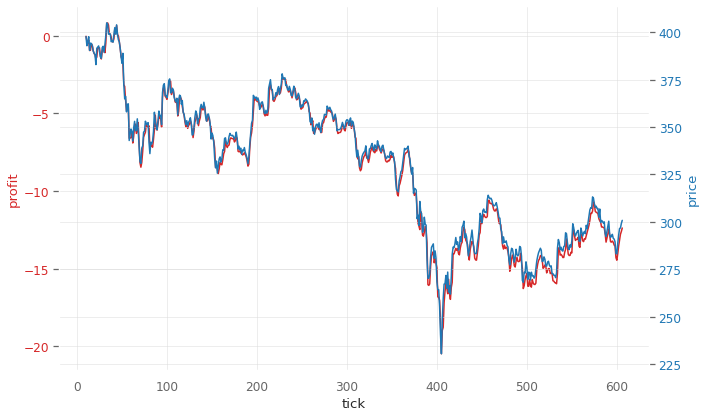

In [ ]:
# test env
 
env = CryptoEnv(df=test_df, ep_len=len(test_df), window_size=10)
observation = env.reset()
 
while True:
    # observation = observation[np.newaxis, ...]
    observation = np.repeat(observation[np.newaxis, ...], 4, axis=0)
 
    # action = env.action_space.sample()
    action, states = model.predict(observation, deterministic=True)
    observation, reward, done, info = env.step(action[0])
    # observation, reward, done, info = env.step(action)
 
    # env.render()
    if done:
        print("info:", info)
        env.info()
        break    
# plt.cla()
# env.render_all()
# plt.show()

In [ ]:
env.graph_benchmark

[-24.52072668874836]

In [ ]:
observation = env.reset()
a,b = model.predict(np.repeat(observation[np.newaxis, ...], 4, axis=0), deterministic=True)
# a=a[0]
print(a[0])
# observation.shape

[-0.12957194]


In [ ]:

start = start_index+1
end = start+len(env.history['balance'])
nw = pd.Series(env.history['balance'], index=df.index[start:end])
# nw.pct_change().iloc[1:]
env.history['balance']

In [ ]:
env.history['profit']

[-0.0375,
 -0.33988462985660134,
 -0.4761843335550338,
 -0.27287526956915825,
 -0.9539810459802767,
 -0.9276234739076585,
 -0.5236167754744884,
 -0.6312069303950465,
 -0.9628016686200681,
 -1.143233285058568,
 -1.22812434873249,
 -1.4839638947328582,
 -1.372014445242496,
 -0.8162943153443621,
 -0.7686993499494292,
 -0.7809507074904559,
 -1.3049000340314478,
 -1.495040507087515,
 -1.012314942193416,
 -0.7296982944860247,
 -0.7302350771765873,
 -1.092055643263734,
 -0.48418243605840416,
 0.7682404334778766,
 0.8280354000957686,
 0.6859612326818934,
 0.09297894221308525,
 0.09941074337664305,
 -0.0879788665817614,
 -0.38637939668083165,
 -0.39528971336972063,
 -0.19333170142308517,
 0.4563315056411397,
 0.20307239172490196,
 0.6623096445063993,
 0.07853879551200862,
 -0.0186539412821503,
 -0.389136206772082,
 -0.8126436422895039,
 -1.353799732614516,
 -1.5288156742764727,
 -1.8172848636302208,
 -3.14874133210011,
 -3.2644519792251456,
 -4.1603748428299925,
 -4.810213525343647,
 -4.6014183

[Performance Metrics]

                           Strategy
-------------------------  -----------------------
Start Period               2021-06-06
End Period                 2021-06-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          32,909.06%
CAGR%                      2.0147078324538356e+40%

Sharpe                     0.85
Sortino                    3.73
Sortino/√2                 2.63

Max Drawdown               -155.39%
Longest DD Days            8
Volatility (ann.)          1473.74%
Calmar                     1.2965869131315164e+38
Skew                       17.46
Kurtosis                   359.34

Expected Daily %           0.98%
Expected Monthly %         32909.06%
Expected Yearly %          32909.06%
Kelly Criterion            28.29%
Risk of Ruin               0.0%
Daily Value-at-Risk        -147.7%
Expected Shortfall (cVaR)  -147.7%

Gain/Pain Ratio            20.1
Gain/Pain (1M)             inf

Payoff Ratio               2.07
P

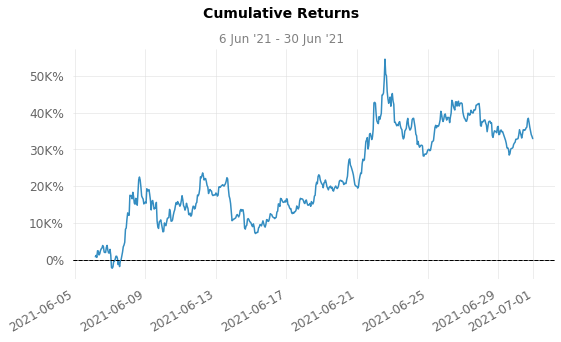

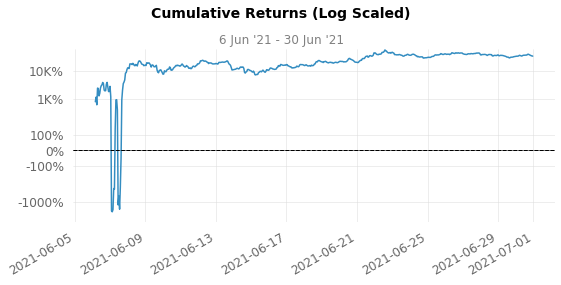

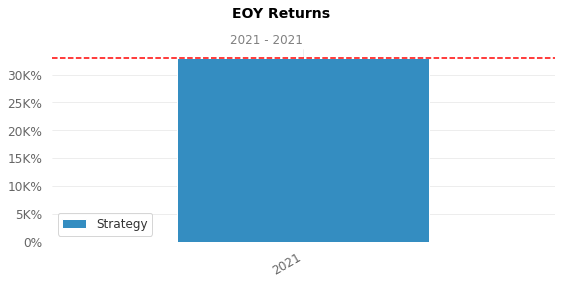

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.



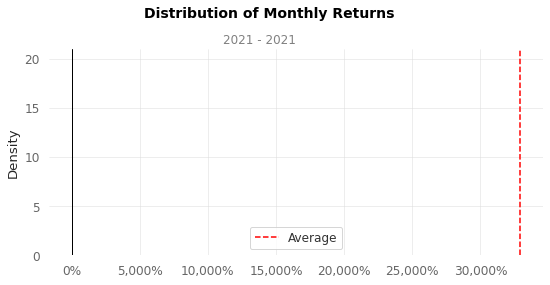

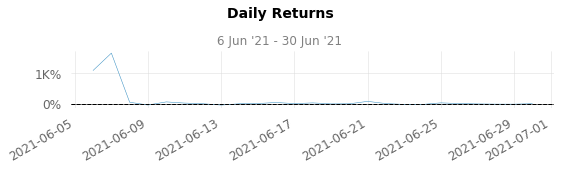

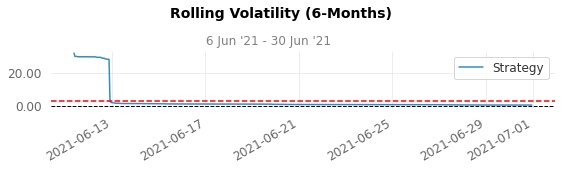

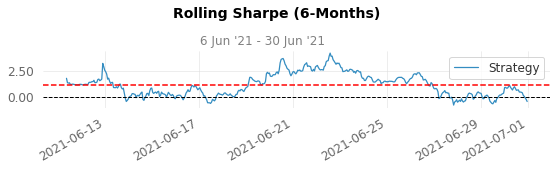

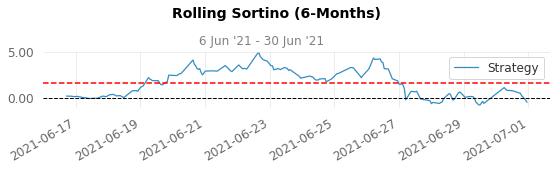

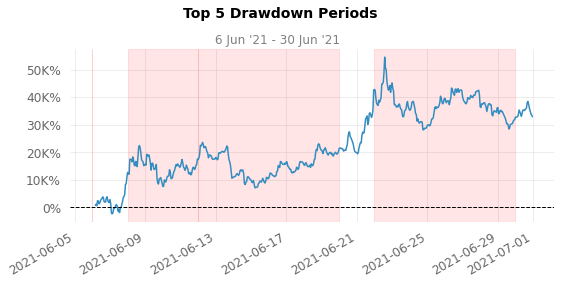

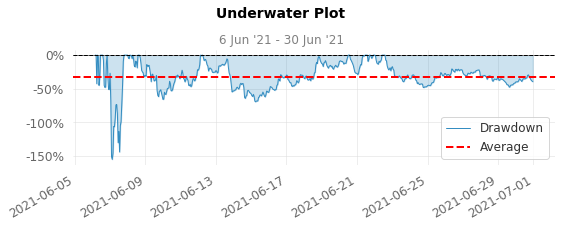

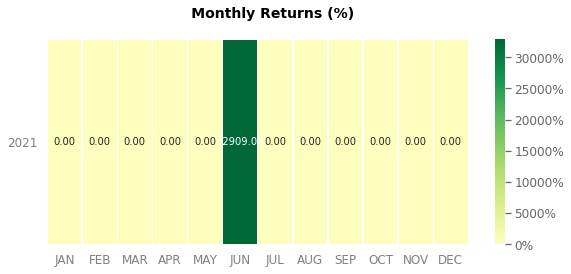

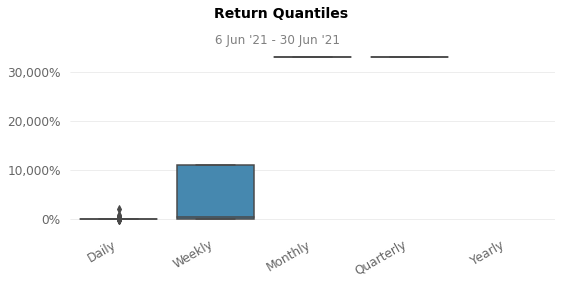

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.



In [ ]:
# quanstats analysis
 
qs.extend_pandas()
start = window_size+1
end = start+len(env.history['profit'])
net_worth = pd.Series(env.history['profit'], index=test_df.index[start:end])
returns = net_worth.pct_change().iloc[1:]
 
qs.reports.full(returns)
qs.reports.html(returns, output='a2c_quantstats.html')

In [ ]:
import time
from prefixed import Float
 
model.save(f"{crypto}/finalest/BNBUSDT_LSTM_TA128_RL_PPO2_default-{eps}eps({Float(ts):.2h}ts)-{time.time()}")